In [3]:
import sys
sys.path.append('../..')

In [4]:
import numpy as np

In [5]:
from pde.grids import UnitGrid, CartesianGrid
from pde.fields import ScalarField, VectorField, Tensor2Field, FieldCollection
from pde.pdes.base import PDEBase
from pde.pdes import *
from pde.storage import MemoryStorage
from pde.visualization import plot_magnitudes

# Vector Diffusion

In [6]:
class DiffusionVectorPDE(PDEBase):
    def __init__(self, diffusivity: float = 1, bc = 'natural'):
        super().__init__()
        self.diffusivity = diffusivity
        self.bc = bc
            
    def evolution_rate(self, state, t: float = 0):
        return self.diffusivity * state.laplace(bc=self.bc, label='evolution rate')

In [7]:
grid = CartesianGrid([[0, 1], [0, 1]], 16)
v = VectorField.from_scalars([ScalarField.from_expression(grid, 'y'), ScalarField(grid, 0)], label='velocity')

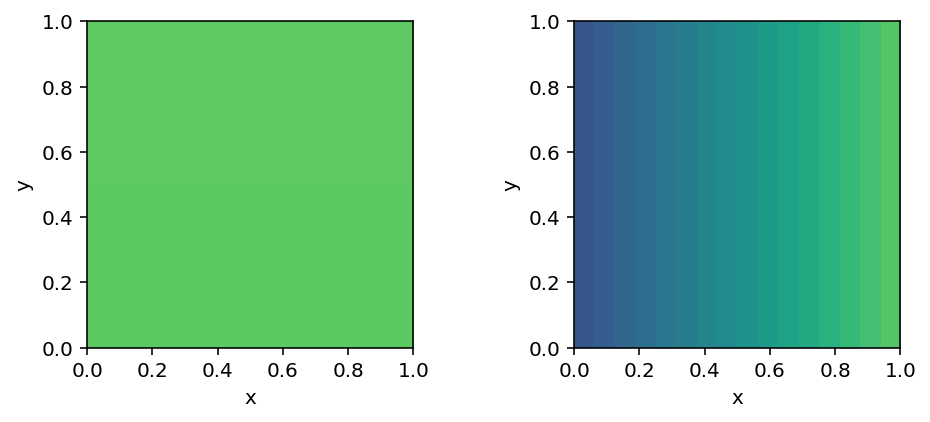

In [8]:
bc_y = [{'value': [0, 0.5]}, {'value': [1, 0]}]
bc_y = 'natural'
bc_x = [{'derivative': [0, -1]}, {'derivative': [0, 1]}]
eq = DiffusionVectorPDE(bc=[bc_x, bc_y])
sol = eq.solve(v, t_range=1, dt=1e-3)
FieldCollection([sol[0], sol[1]]).plot(vmin=-1, vmax=1);

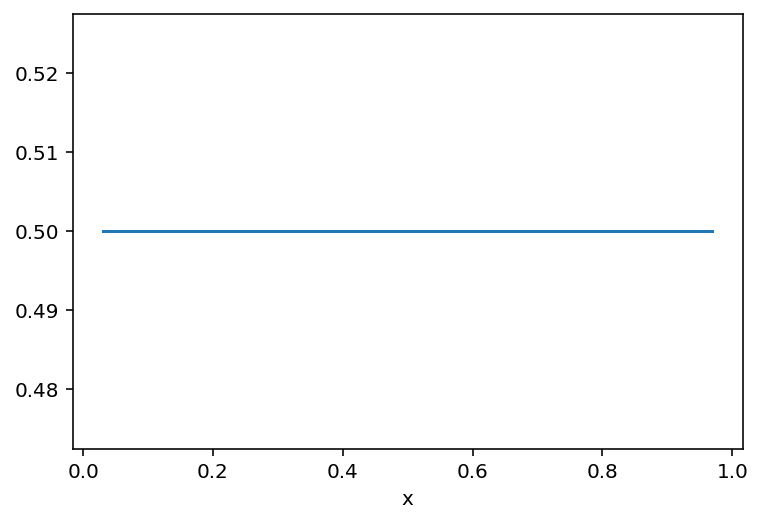

In [141]:
sol[0].plot_line()

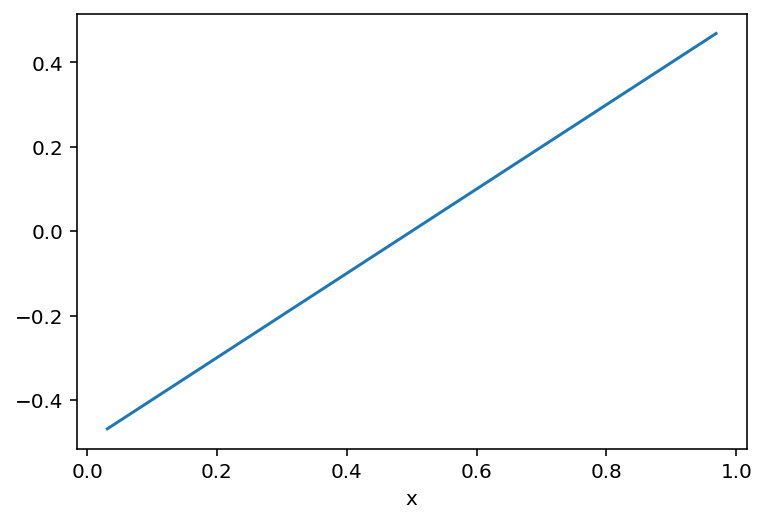

In [142]:
sol[1].plot_line()

# Compressible Navier Stokes

In [9]:
class NavierStokesCompressiblePDE(PDEBase):
    """ minimal model of a custom pde
    
    Taken from https://en.wikipedia.org/wiki/Chafee–Infante_equation
    """
    
    def __init__(self, viscosity=1, factor=.1, bc_u='natural', bc_rho='natural'):
        super().__init__()
        self.viscosity = viscosity
        self.factor = factor
        
        self.bc_u = bc_u
        self.bc_rho = bc_rho
                
            
    def evolution_rate(self, state, t=0):
        u, rho = state  # velocity and density
        
        flux = rho * u
        u_tensor = u.outer_product(u)
        rho_grad = rho.gradient(self.bc_rho)

        # second bc: no flow penetrating the boundary
        rho_t = -rho_grad @ u - rho * u.divergence('natural') + 1e-3 * rho.laplace(self.bc_rho)
        
        flux_t = (self.viscosity * u.laplace(self.bc_u)
                  - rho_grad @ u_tensor - rho * u_tensor.divergence(self.bc_u)
                  - self.factor * rho_grad)
        u_t = (flux_t - u * rho_t) / rho
        u_t.label = 'Velocity evolution'
        rho_t.label = 'Density evolution'
        return FieldCollection([u_t, rho_t])

In [10]:
grid = CartesianGrid([[-1, 1], [-1, 1]], 16, periodic=[False, False])
# u = VectorField.from_scalars([ScalarField.from_expression(grid, '1 - y**2'), ScalarField(grid, 0)], label='Velocity')
u = VectorField(grid, label='Velocity')
rho = ScalarField(grid, 1, label='Density')
state = FieldCollection([u, rho])

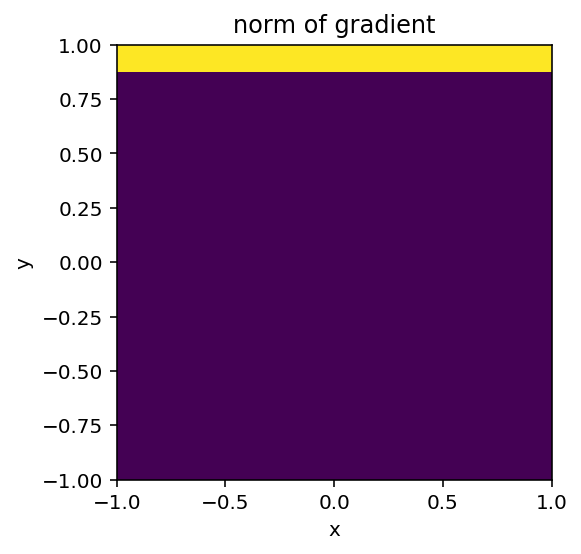

In [11]:
bc_u_x = {'value': [0, 0]}
bc_u_y = [{'value': [0, 0]}, {'value': [.1, 0]}]  # impose flow on top
u.gradient([bc_u_x, bc_u_y]).plot()

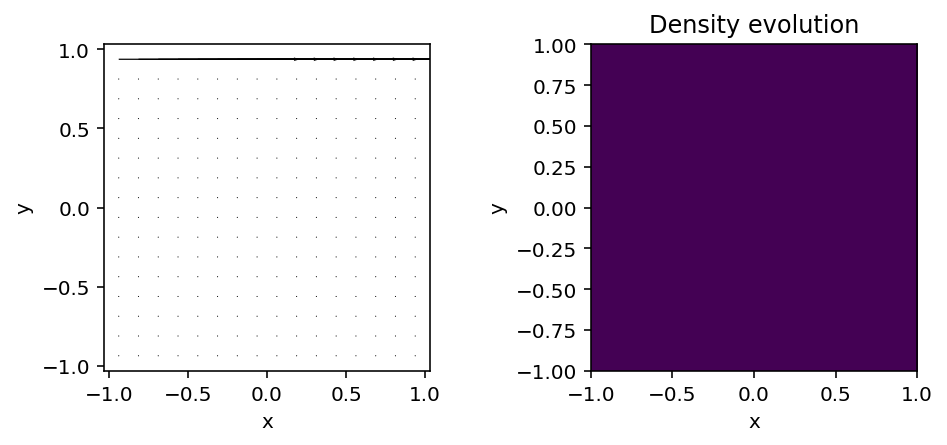

In [12]:
eq = NavierStokesCompressiblePDE(viscosity=10, factor=1, bc_u=[bc_u_x, bc_u_y])
rate = eq.evolution_rate(state)
rate.plot();

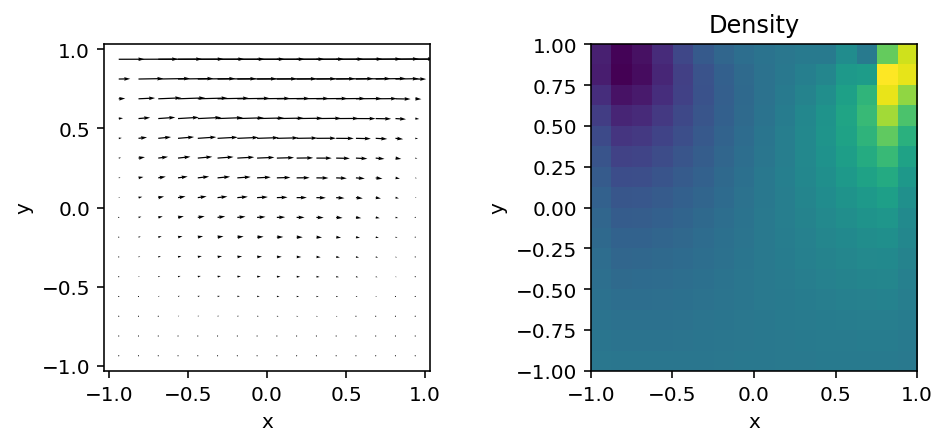

In [13]:
storage = MemoryStorage()
sol = eq.solve(state, method='scipy', t_range=5, dt=1e-3,
               tracker=['progress', 'steady_state', 'consistency', storage.tracker(interval=1)])
sol.plot()

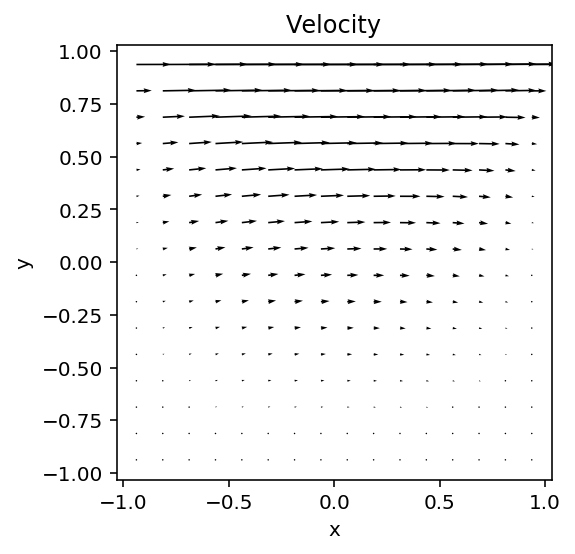

In [14]:
sol[0].plot_vector()

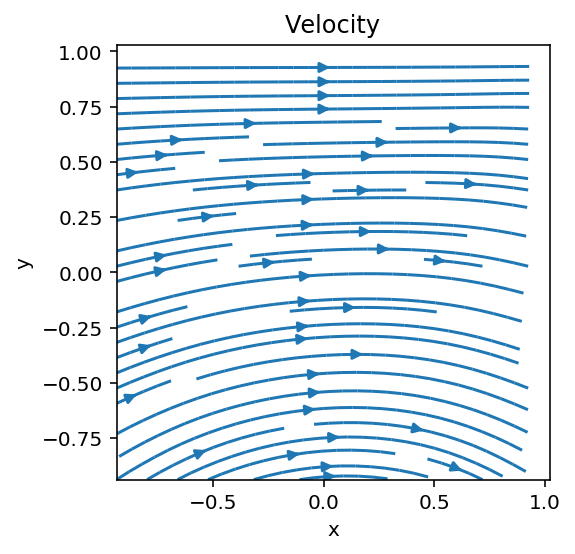

In [15]:
sol[0].plot_vector('streamplot')

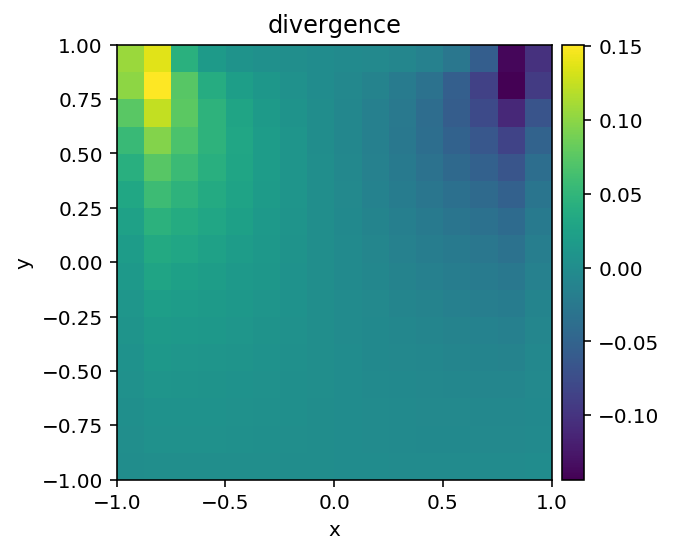

In [16]:
sol[0].divergence('natural').plot(colorbar=True)

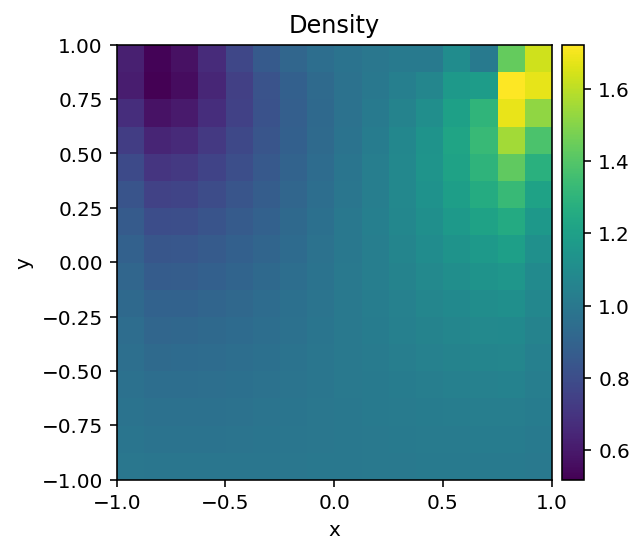

In [17]:
sol[1].plot(colorbar=True)

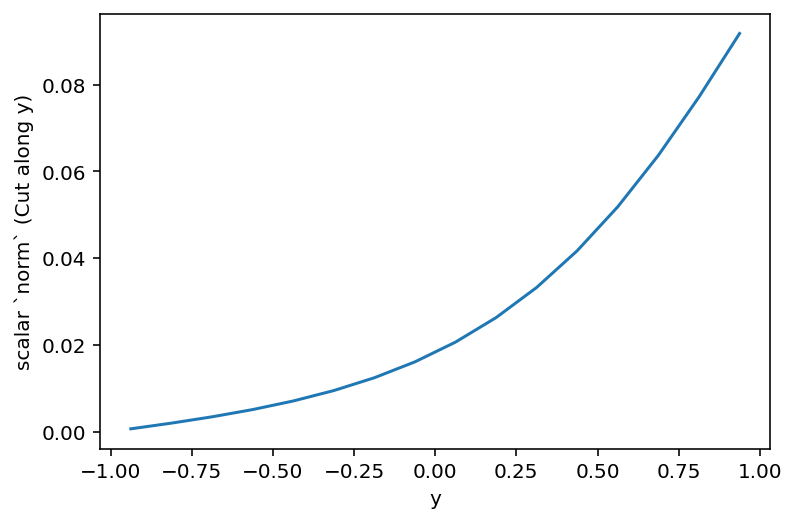

In [18]:
sol[0].plot_line(extract='cut_y')

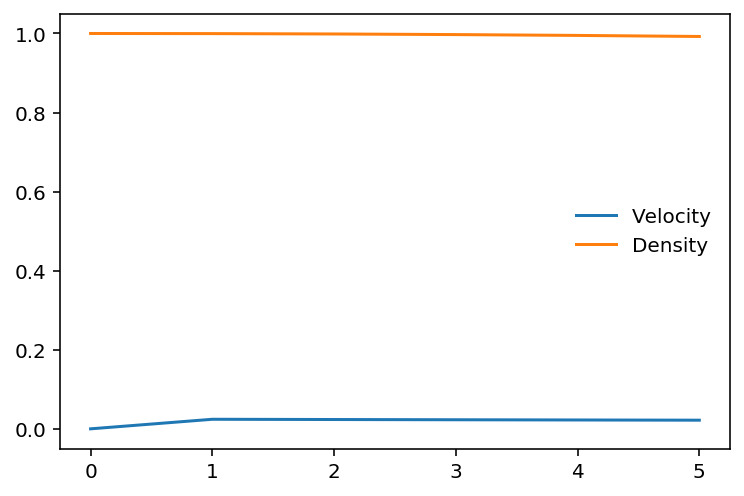

In [19]:
plot_magnitudes(storage)